# Analyzing the `lein-topology` function dependency network

In [82]:
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil

import sand.graph as graph
import sand.cytoscape.app as app
import sand.cytoscape.positions as scp

from sand.cytoscape.themes import ops, colors
from sand.csv import csv_to_dicts
from sand.groups import labels_to_groups, namespaces, fqn_to_groups

import matplotlib.pyplot as plt

%matplotlib notebook

### `graph.from_edges` with a list of dictionaries

Use `graph.from_edges` with an adjacency list consisting of two vertex names and an edge weight represented as a List of Dictionaries.

In [73]:
network_name = "faad435"
network_collection = "lein-topology"

data_path = "./data/" + network_collection + "-" + network_name
edgelist_file = data_path + ".csv"

edgelist_data = csv_to_dicts(edgelist_file,header=['source', 'target', 'weight'])
edgelist_data[:5]

[OrderedDict([('source', 'topology.dependencies/dependencies'),
              ('target', 'clojure.core/defn-'),
              ('weight', '1')]),
 OrderedDict([('source', 'topology.dependencies/filtered'),
              ('target', 'clojure.core/filter'),
              ('weight', '1')]),
 OrderedDict([('source',
               'topology.dependencies-test/should-compute-fn-calls-in-namespace'),
              ('target', 'clojure.core/defn'),
              ('weight', '1')]),
 OrderedDict([('source', 'example/test-when'),
              ('target', 'clojure.core/cons'),
              ('weight', '1')]),
 OrderedDict([('source', 'leiningen.topology/topology'),
              ('target', 'org.clojure/clojure'),
              ('weight', '1')])]

In [38]:
g = graph.from_edges(edgelist_data)
g.summary()

'IGRAPH DNW- 106 204 -- \n+ attr: group (v), indegree (v), label (v), name (v), outdegree (v), weight (e)'

## Is the graph simple?

A graph is simple if it does not have multiple edges between vertices and has no loops, i.e. an edge with the same source and target vertex.

A graph that isn't simple can cause problems for some network analytics algorithms.

In [39]:
g.is_simple()

True

## Degree Centrality

Identify the nodes with highest outdegree and indegree.

Outdegree represents the vertices that have the most dependencies, i.e. call the most number of functions. These functions could potentially be split into smaller, more cohesive functions.

Indegree represents the vertices are depended on the most...changing them will have the most impact on other parts of the system.

In [40]:
degree, count = zip(*[(bin_left_side, bin_count) for bin_left_side, bin_right_side, bin_count in g.degree_distribution().bins()])

<IPython.core.display.Javascript object>


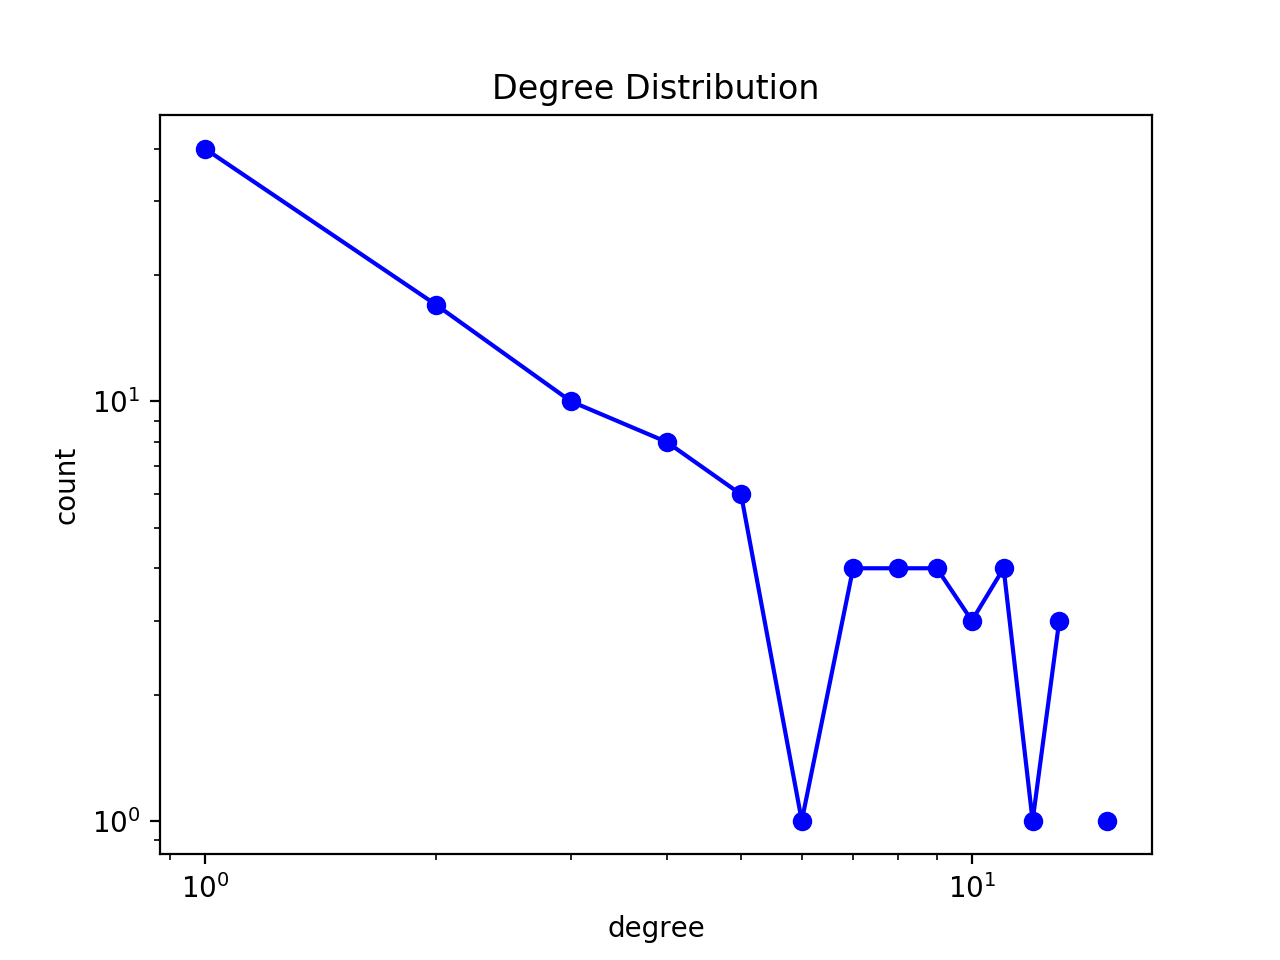

In [41]:
plt.title("Degree Distribution")
plt.ylabel("count")
plt.xlabel("degree")
infig, = plt.loglog(degree, count, 'b-', marker='o')

In [42]:
g.vs['outdegree'][:5]

[12, 0, 8, 0, 13]

In [43]:
g.vs['indegree'][:5]

[1, 11, 1, 7, 0]

Which vertices have a degree of more than some majority percentage of the maxdegree?

In [44]:
g.maxdegree(mode='IN')

13

In [45]:
g.maxdegree(mode='OUT')

15

In [46]:
score = g.maxdegree() * .80

### These functions call the highest number of others and could potentially be split:

In [47]:
[v['name'] for v in g.vs.select(lambda vertex: vertex['outdegree'] >= score)]

['topology.dependencies/dependencies',
 'topology.dependencies-test/should-compute-fn-calls-in-namespace',
 'leiningen.topology/topology',
 'topology.core-test/syntax-quotes-add-seq-concat-list']

### Changing these functions will have the most impact on other parts of the system:

In [48]:
[v['name'] for v in g.vs.select(lambda vertex: vertex['indegree'] >= 4)]

['clojure.core/defn-',
 'clojure.core/filter',
 'clojure.core/defn',
 'clojure.core/seq',
 'clojure.test/deftest',
 'clojure.core/symbol',
 'clojure.core/->>',
 'clojure.core/range',
 'clojure.core/map',
 'clojure.test/is',
 'clojure.core/list',
 'clojure.core/=',
 'clojure.core/fn']

In this case, `clojure.core` and `clojure.test` namespaces have the most dependencies...unsurprising, given these are the foundational libraries of the language. These are good candidates to filter out of a visualization, since they often don't add deep insight to the aspects of the design specific to the program.

## Initial Clustering based on Namespace

Groups represent modules or communities in the network. Groups are based on the labels by default.

In [50]:
g.vs['group'][:5]

[22, 76, 84, 36, 33]

The vertices in the `lein topology` data set contain fully-qualified namespaces for functions. Grouping by name isn't particularly useful here:

In [51]:
len(set(functions.vs['group']))

106

In [52]:
len(functions.vs)

106

Because `sandbook` was build specifically for analyzing software and system networks, a `fqn_to_groups` grouping function is built in:

In [54]:
g.vs['group'] = fqn_to_groups(g.vs['label'])

In [56]:
len(set(g.vs['group']))

18

This is a much more managable number of groups.

Namespaces may also be useful as a separate attribute on the vertices:

In [60]:
g.vs['namespace'] = namespaces(g.vs['label'])

## Extract the subgraph of local namespaces 

There are some analyses where it will be useful to see all the vertices. For the high-level architecture diagram, we can focus on the functions local to the library's namespaces. We'll also keep functions that have side-effects to see if these are isolated to only a few key parts of the program:

In [61]:
# List all patterns of vertex names that we want to keep:
names_to_keep = ('topology', 'clojure.core/*err*', 'clojure.core/println')

lv = g.vs(lambda v: any(match in v['label'] for match in names_to_keep))
lg = g.subgraph(lv)

# Recompute degree after building the subgraph:
lg.vs['indegree'] = lg.degree(mode="in")
lg.vs['outdegree'] = lg.degree(mode="out")

lg.summary()

'IGRAPH DNW- 25 26 -- \n+ attr: group (v), indegree (v), label (v), name (v), namespace (v), outdegree (v), weight (e)'

# Visualizing the network in Cytoscape

## Verify that Cytoscape is running and get the current version

In [67]:
app.print_version()

{
  "apiVersion": "v1",
  "cytoscapeVersion": "3.5.1"
}


 ## Load the network into Cytoscape with a default layout

In [70]:
# Create py2cytoscape client
cy = CyRestClient()

In [71]:
# Optional: delete existing Cytoscape sessions.
cy.session.delete()

In [74]:
# Load the network
network = cy.network.create_from_igraph(lg, name=network_name, collection=network_collection)

## Layout

In [80]:
# Apply default layout
cy.layout.apply(name='force-directed', network=network)

In [83]:
# Load layout coordinates from a previous session
positions_file = data_path + "-positions.csv"
scp.layout_from_positions_csv(network, positions_file, cy)

## Customize the style

Use one of the included themes, or build your own.

In [77]:
style = cy.style.create('Ops')
style.update_defaults(ops.settings)

# Map the label property in the igraph data to Cytoscape's NODE_LABEL visual property
style.create_passthrough_mapping(column='label', vp='NODE_LABEL', col_type='String')

### Give each namespace a unique color:

In [78]:
border_colors = {
  'topology.finder': colors.BRIGHT_YELLOW,
  'topology.dependencies': colors.BRIGHT_ORANGE,
  'topology.dependencies-test': colors.BRIGHT_ORANGE,
  'topology.qualifier': colors.BRIGHT_PURPLE,
  'topology.symbols': colors.BRIGHT_BLUE,
  'clojure.core': colors.BRIGHT_RED,
  'topology.printer': colors.BRIGHT_RED,
  'leiningen.topology': colors.BRIGHT_WHITE,
}

fill_colors = {
  'topology.finder': colors.DARK_YELLOW,
  'topology.dependencies': colors.DARK_ORANGE,
  'topology.dependencies-test': colors.DARK_ORANGE,
  'topology.qualifier': colors.DARK_PURPLE,
  'topology.symbols': colors.DARK_BLUE,
  'clojure.core': colors.DARK_RED,
  'topology.printer': colors.DARK_RED,
  'leiningen.topology': colors.DARK_WHITE,
}

style.create_discrete_mapping(column='namespace', col_type='String', vp='NODE_FILL_COLOR', mappings=fill_colors)
style.create_discrete_mapping(column='namespace', col_type='String', vp='NODE_BORDER_PAINT', mappings=border_colors)

In [79]:
cy.style.apply(style, network)

## Save the updated layout coordinates if you make changes

A benefit of this workflow is the ability to manually tweak the algorithmic network layout in Cytoscape.

After making changes, save the coordinates for a later session:

In [84]:
scp.positions_to_csv(network=network, path=positions_file)

## Generate an SVG export

Position the network in Cytoscape the way you want it, then trigger this export.
When iterating, run all cells above, then all cells below this point to avoid race conditions with cytoscape's renderer.

In [90]:
# Hide all panels in the UI
app.hide_panels()

True

In [110]:
# Fit to the window:
cy.layout.fit(network=network)

In [111]:
view_id = network.get_views()[0]
view = network.get_view(view_id=view_id, format='view')

In [112]:
# Zoom out slightly:
view.update_network_view('NETWORK_SCALE_FACTOR', 0.65)

In [113]:
# Shift the network to the left:
view.update_network_view('NETWORK_CENTER_X_LOCATION', 750.0)

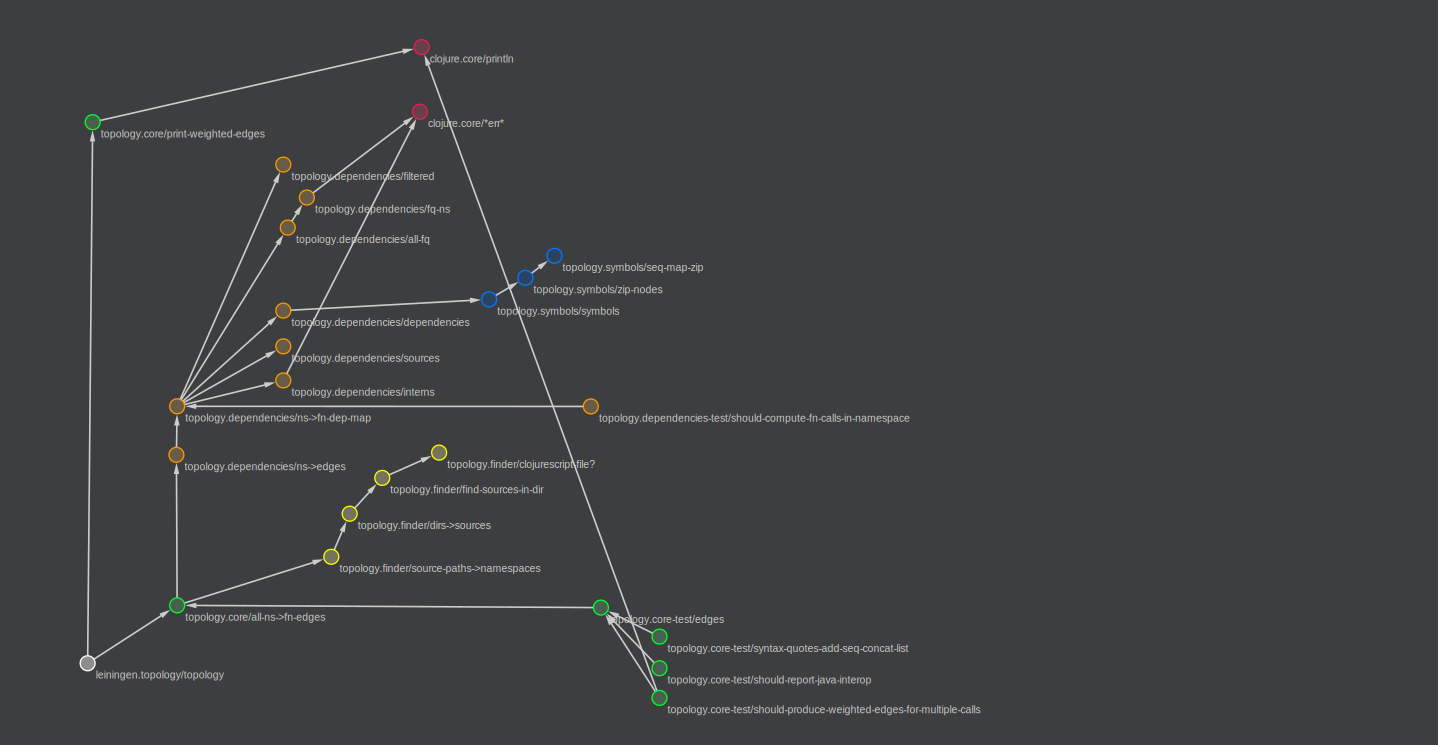

In [114]:
from IPython.display import SVG, display

svg_data = network.get_svg()
display(SVG(svg_data))

In [115]:
# Write the svg to a file if everything looks good:
with open(data_path + '.svg', 'wb') as f:
    f.write(svg_data)

## To create an updated structure after making new commits:

* Generate an updated network.
* Copy the previous position file to use as a starting point for the next visualization.
* Open Cytoscape or destroy existing collections if Cytoscape is already running.
* Run all cells to load the visualization.
* [Save the new layout if you make changes to node positions](/notebooks/architecture.ipynb#Save-the-updated-layout-coordinates-if-you-make-changes).

## Visualizing the network with a Dependency Structure Matrix (DSM)

Each row shows a function's dependencies.

Each column shows callers impacted by the function.

This follows the IR/FAD DSM convention.

Ordering by group / modules gives us a read on how well the system accomplishes the goal of loosely coupled and highly cohesive modules.

In [116]:
from sand.matrix import matrix

from bokeh.plotting import show, output_notebook
from bokeh.palettes import all_palettes

output_notebook()

Loading BokehJS ...

### Create a color palette

We want to choose a color palette so that groups stand out.

Find the number of groups that you have assigned to your vertices:

In [133]:
num_groups = max(set(lg.vs['group']))
num_groups

17

Now we need to [choose an appropriate palette](http://bokeh.pydata.org/en/latest/docs/reference/palettes.html) that accomodates this number of groups and achieves the desired visual separation.

As a general rule, you'll need one of the [large palettes](http://bokeh.pydata.org/en/latest/docs/reference/palettes.html#large-palettes) for > 20 groups.

Pass the name of the palette you choose to the `all_palettes` function:

In [135]:
palette = all_palettes['Category20'][num_groups + 1]

### Determine the order to sort the vertex labels

The matrix visualization will be rendered according to a vertex attribute used as the `sort_by` parameter in `matrix`.

In [129]:
lg.vs.attributes()

['name', 'indegree', 'outdegree', 'label', 'group', 'namespace']

### Render the matrix



In [143]:
p = matrix(lg, 'indegree', "{}-{} by indegree".format(network_collection, network_name), 900, palette)
show(p)

In [144]:
p = matrix(lg, 'outdegree', "{}-{} by outdegree".format(network_collection, network_name), 900, palette)
show(p)

In [145]:
p = matrix(lg, 'group', "{}-{} by group".format(network_collection, network_name), 900, palette)
show(p)